# A Hierarchical model for Rugby prediction
* @Author: Peadar Coyle
* @email: peadarcoyle@googlemail.com
* @date: 31/12/15

I came across the following blog post on http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/
* Based on the work of [Baio and Blangiardo](www.statistica.it/gianluca/Research/BaioBlangiardo.pdf)
In this example, we're going to reproduce the first model described in the paper using PyMC3.

Since I am a rugby fan I decide to apply the results of the paper Bayesian Football to the Six Nations.
Rugby is a physical sport popular worldwide.
* Six Nations consists of Italy, Ireland, Scotland, England, France and Wales
* Game consists of scoring tries (similar to touch downs) or kicking the goal.
* Average player is something like 100kg and 1.82m tall.
* Paul O'Connell the Irish captain is Height: 6' 6" (1.98 m) Weight: 243 lbs (110 kg)

We will use a data set only consisting of the Six Nations 2014 data, and use this to build a generative and explainable model about the Six Nations 2015.

# Motivation
Your estimate of the strength of a team depends on your estimates of the other strengths

Ireland are a stronger team than Italy for example - but by how much?

Source for Results 2014 are Wikipedia.
I handcrafted these results
Small data
* We want to infer a latent parameter - that is the 'strength' of a team based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team. 
* Probabilistic Programming is a brilliant paradigm for modeling these **latent** parameters

In [2]:
!date

import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
%matplotlib inline
import pymc3 as pm, theano.tensor as tt

Sun Jan 31 14:32:48 CET 2016


This is a Rugby prediction exercise. So we'll input some data

In [3]:
data_csv = StringIO("""home_team,away_team,home_score,away_score
Wales,Italy,23,15
France,England,26,24
Ireland,Scotland,28,6
Ireland,Wales,26,3
Scotland,England,0,20
France,Italy,30,10
Wales,France,27,6
Italy,Scotland,20,21
England,Ireland,13,10
Ireland,Italy,46,7
Scotland,France,17,19
England,Wales,29,18
Italy,England,11,52
Wales,Scotland,51,3
France,Ireland,20,22""")

# What do we want to infer?
* We want to infer the latent paremeters (every team's strength) that are generating the data we observe (the scorelines).
* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

* Often we don't know what the Bayesian Model is explicitly, so we have to 'estimate' the Bayesian Model'
* If we can't solve something, approximate it.

* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.
* Fortunately, this algorithm can be applied to almost any model.
# What do we want?
We want to quantify our uncertainty
We want to also use this to generate a model
We want the answers as distributions not point estimates

# What assumptions do we know for our 'generative story'?
* We know that the Six Nations in Rugby only has 6 teams - they each play each other once
* We have data from last year!
* We also know that in sports scoring is modelled as a Poisson distribution
* We consider home advantage to be a strong effect in sports

# The model.

The league is made up by a total of T= 6 teams, playing each other once 
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
$y_{gi}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$
where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>





We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$


* The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
* The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

* Conversely, for each t = 1, ..., T, the team-specific effects are modelled as exchangeable from a common distribution:

* $att_{t} \; \tilde\;\; Normal(\mu_{att},\tau_{att})$ and $def_{t} \; \tilde\;\;Normal(\mu_{def},\tau_{def})$

In [4]:
df = pd.read_csv(data_csv)

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

* We did some munging above and adjustments of the data to make it **tidier** for our model. 
* The log function to away scores and home scores is a standard trick in the sports analytics literature
# Building of the model 
* We now build the model in PyMC3, specifying the global parameters, and the team-specific parameters and the likelihood function 


In [5]:
model = pm.Model()
with pm.Model() as model:
    # global model parameters
    home        = pm.Normal('home',      0, .0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, .0001)
    
    # team-specific model parameters
    atts_star   = pm.Normal("atts_star", 
                           mu   =0,
                           tau  =tau_att, 
                           shape=num_teams)
    defs_star   = pm.Normal("defs_star", 
                           mu   =0,
                           tau  =tau_def,  
                           shape=num_teams) 
 
    atts        = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs        = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[away_team] + defs[home_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


* We specified the model and the likelihood function

* All this runs on a Theano graph under the hood
* Now we need to fit our model using the Maximum A Posteriori algorithm to decide where to start out No U Turn Sampler

 [-----------------100%-----------------] 2000 of 2000 complete in 4.2 sec

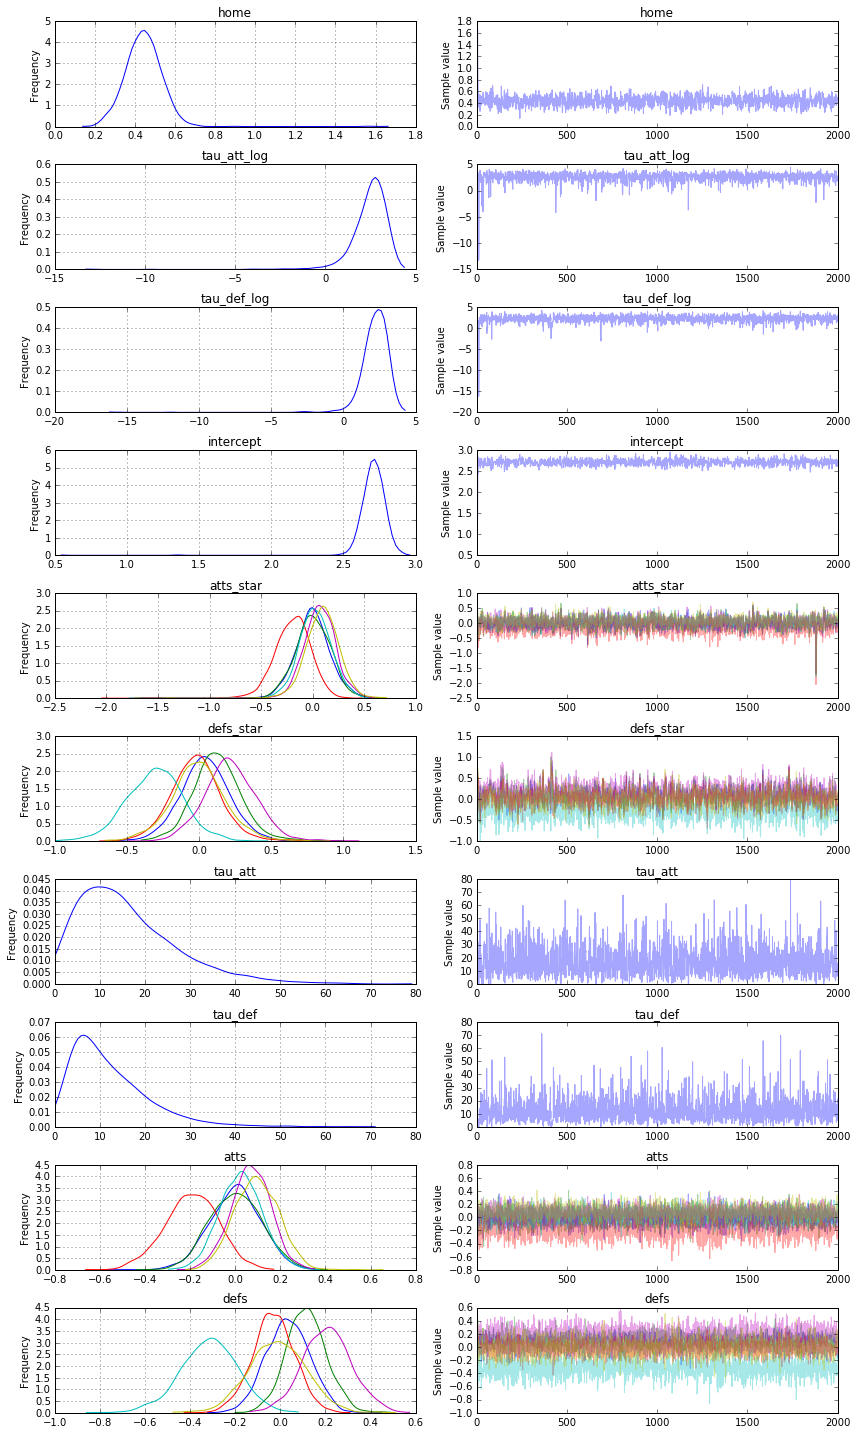

In [6]:
with model:

    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=True)

    pm.traceplot(trace)

# Results
From the above we can start to understand the different distributions of attacking strength and defensive strength.
These are probabilistic estimates and help us better understand the uncertainty in sports analytics

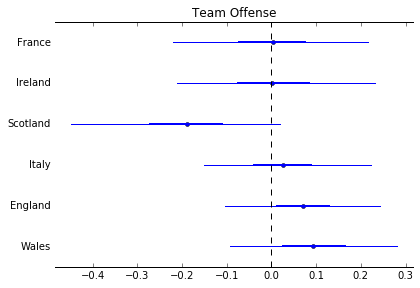

In [7]:
pm.forestplot(trace, vars=['atts'], ylabels=['France', 'Ireland', 'Scotland', 'Italy', 'England', 'Wales'], main="Team Offense")

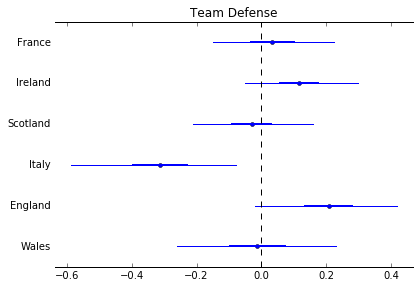

In [8]:
pm.forestplot(trace, vars=['defs'], ylabels=['France', 'Ireland', 'Scotland', 'Italy', 'England', 'Wales'], main="Team Defense")

# Covariates.
We should do some exploration. of the variables too

In [22]:
df_trace = pm.trace_to_dataframe(trace[:1000])



/Users/peadarcoyle/anaconda/envs/pymc3_examples/lib/python3.5/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


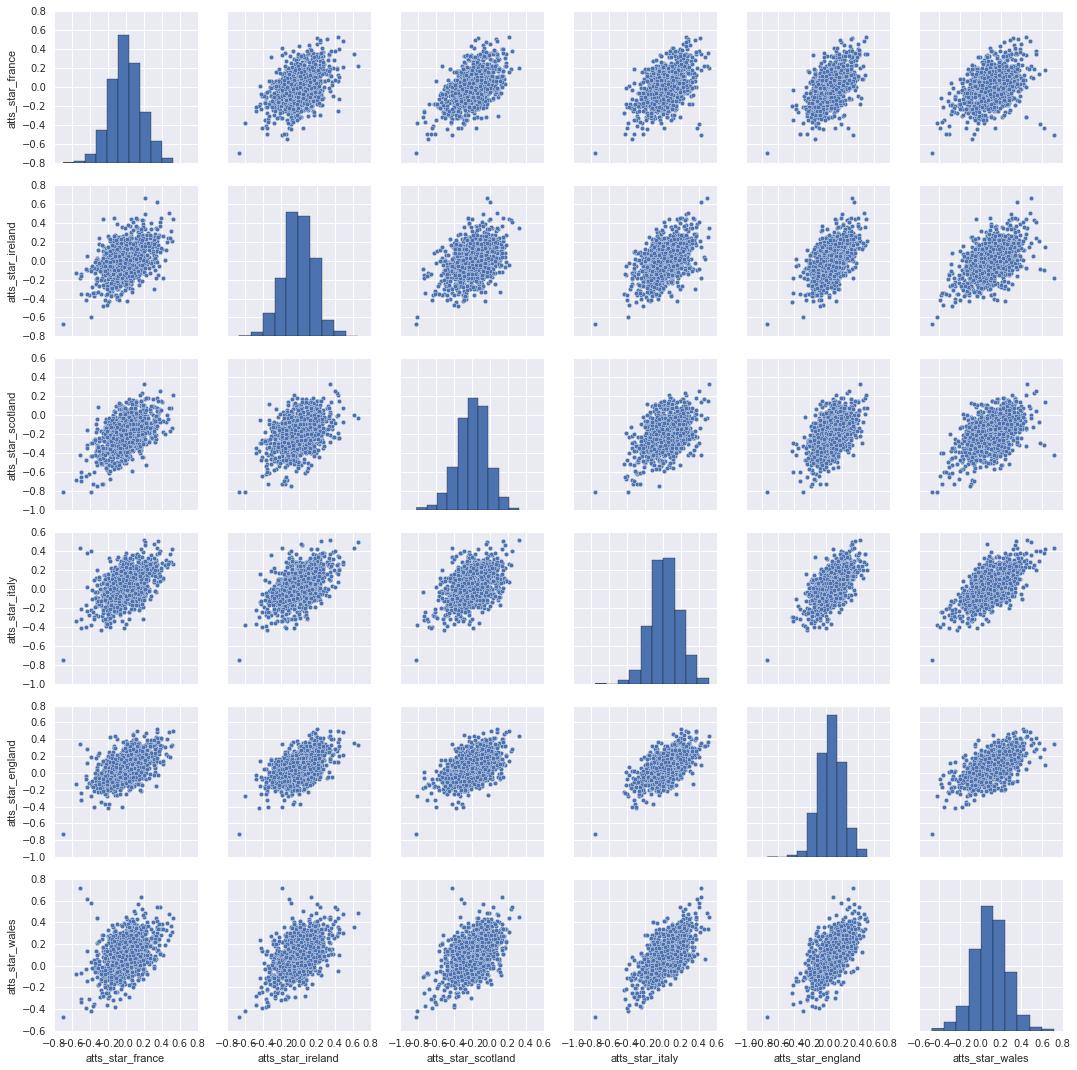

In [21]:
import seaborn as sns
df_trace_att = df_trace[['atts_star__0','atts_star__1',
 'atts_star__2',
 'atts_star__3',
 'atts_star__4',
 'atts_star__5']]
df_trace_att.rename(columns={'atts_star__0':'atts_star_france','atts_star__1':'atts_star_ireland',
 'atts_star__2':'atts_star_scotland',
 'atts_star__3':'atts_star_italy',
 'atts_star__4':'atts_star_england',
 'atts_star__5':'atts_star_wales'}, inplace=True)
_ = sns.pairplot(df_trace_att)

We observe that there isn't a lot of correlation between these covariates, other than the weaker teams like Italy have a more negative distribution of these variables. 
Nevertheless this is a good method to get some insight into how the variables are behaving. 